### (SCLP) Set-Covering Location Problem
- Service is provided to customers within distance $r$ of any facility.
- Sets:
    - $I$: set of customers
    - $J$: set of candidate facility locations
- Parameters:
    - $a_{ij}$: whether customer $i$ is covered by facility at $j$ (distance $\le r$)
        - $
        a_{ij}=\begin{cases}
            1, \quad\text{if customer } i \text{ is covered by a facility at } j\\
            0, \quad\text{O.W.}
        \end{cases}
        $
- Decision variables:
    - $x_j=\begin{cases}
            1, \quad\text{if a facility is installed at } j\\
            0, \quad\text{O.W.}
        \end{cases}
        $
        
<br>

$
\begin{split}
&\text{SCLP}\quad & \text{minimize}\quad \sum\limits_{j\in J}x_{j}\\
&&\begin{split}
\text{subject to}\quad \sum\limits_{j\in J}&a_{ij}\ge1 & \forall i\in I\\
    & x_{j}\in \{0, 1\}\quad\quad & \forall j\in J\\
\end{split}
\end{split}
$

In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from scipy import stats
from gurobipy import Model, GRB, quicksum
%matplotlib inline

In [2]:
# settings
sns.reset_orig
sns.set_style('darkgrid')
sns.set_palette('Set1')

np.set_printoptions(linewidth=200)

In [3]:
# import data
i_data = pd.read_excel('data.xlsx', sheet_name='i_data')
j_data = pd.read_excel('data.xlsx', sheet_name='j_data')
dist_ij = pd.read_excel('data.xlsx', sheet_name='dist_ij').values

In [4]:
# declare the parameters and sets
I = [i for i in range(len(i_data['X'].values))]
J = [j for j in range(len(j_data['X'].values))]
A = [(i, j) for i in I for j in J]

D = 100
a = {(i, j): int(dist_ij[i, j] <= D) for (i, j) in A}

In [5]:
# create model
mdl = Model('SCLP')

Academic license - for non-commercial use only - expires 2022-08-28
Using license file C:\Users\jack4\gurobi.lic


In [6]:
# add model variables
x = mdl.addVars(J, vtype=GRB.BINARY)

In [7]:
# add objective function
mdl.ModelSense = GRB.MINIMIZE
mdl.setObjective(quicksum(x[j] for j in J))

In [8]:
# add the model constraints
mdl.addConstrs(quicksum(a[i,j]*x[j] for j in J) >= 1 for i in I)
mdl.update()

In [9]:
%%time

# optimize
mdl.optimize()

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 100 rows, 20 columns and 1062 nonzeros
Model fingerprint: 0xf503178d
Variable types: 0 continuous, 20 integer (20 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 4.0000000
Presolve removed 100 rows and 20 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.00 seconds
Thread count was 1 (of 16 available processors)

Solution count 2: 3 4 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.000000000000e+00, best bound 3.000000000000e+00, gap 0.0000%
Wall time: 7.97 ms


In [10]:
# opened locations and covered customers
opened = [j for j in J if x[j].X > 0.0]

In [11]:
# update the dataframes
j_data['Opened'] = [int(x[j].X > 0.0) for j in J]

Text(0.5, 1.0, 'Facilities Chosen')

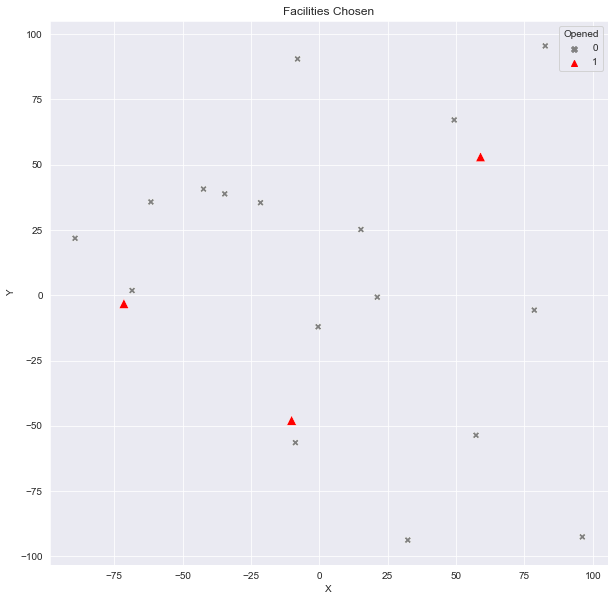

In [12]:
# plot the station locations
fig, ax = plt.subplots(figsize=(10,10))
s = [100 if i == 1 else 50 for i in j_data['Opened'].values]
sns.scatterplot(x='X', y='Y', data=j_data, hue='Opened', palette=['grey', 'red'], style='Opened', markers=('X', '^'), s=s)
plt.title('Facilities Chosen')

Text(0.5, 1.0, 'Facility Coverage')

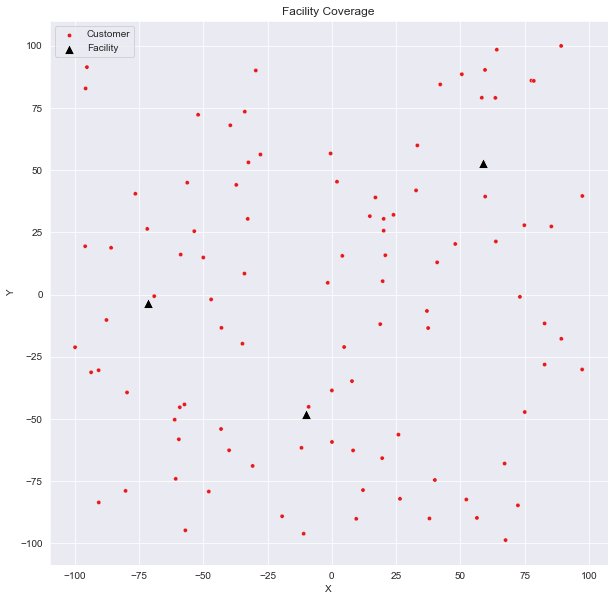

In [13]:
# plot the customer coverage
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(x='X', y='Y', data=i_data, size=1, legend=False, label="Customer")
sns.scatterplot(x='X', y='Y', data=j_data[j_data['Opened'] == 1], s=100, color='black', marker='^', label="Facility")
plt.title('Facility Coverage')

In [14]:
# find objective value
obj_val = sum([int(x[j].X) for j in J])

print('Objective value = ', obj_val)

Objective value =  3
